In [7]:
from efficient_kan import KAN
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import torch
import mplhep as hep
hep.style.use("CMS")
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# device = 'cpu'

In [8]:
X_train=torch.from_numpy(np.load('data/X_train_val.npy')).float().to(device)
y_train=torch.from_numpy(np.load('data/y_train_val.npy')).float().to(device).argmax(dim=1)
X_test=torch.from_numpy(np.load('data/X_test.npy')).float().to(device)
y_test=torch.from_numpy(np.load('data/y_test.npy')).float().to(device).argmax(dim=1)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader objects
batch_size = 64  # Adjust this based on your available memory
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
model = KAN([16,32,5], grid_size=30, spline_order=3, grid_eps=0.05, base_activation=nn.GELU, grid_range=[-2,2])
print(sum(p.numel() for p in model.parameters()))

23520


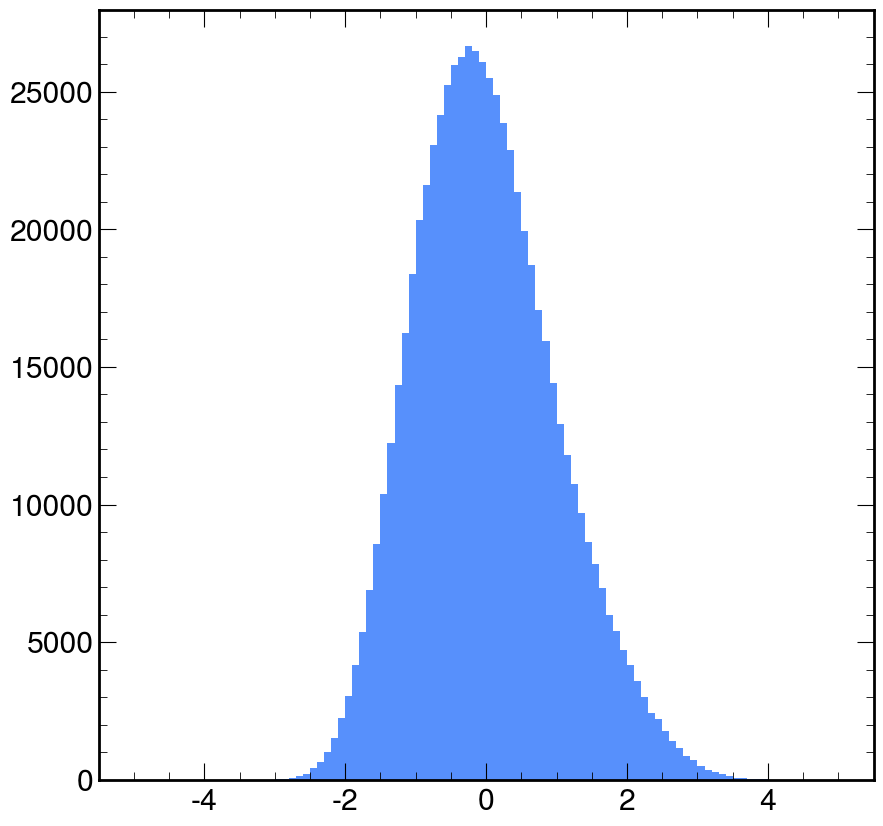

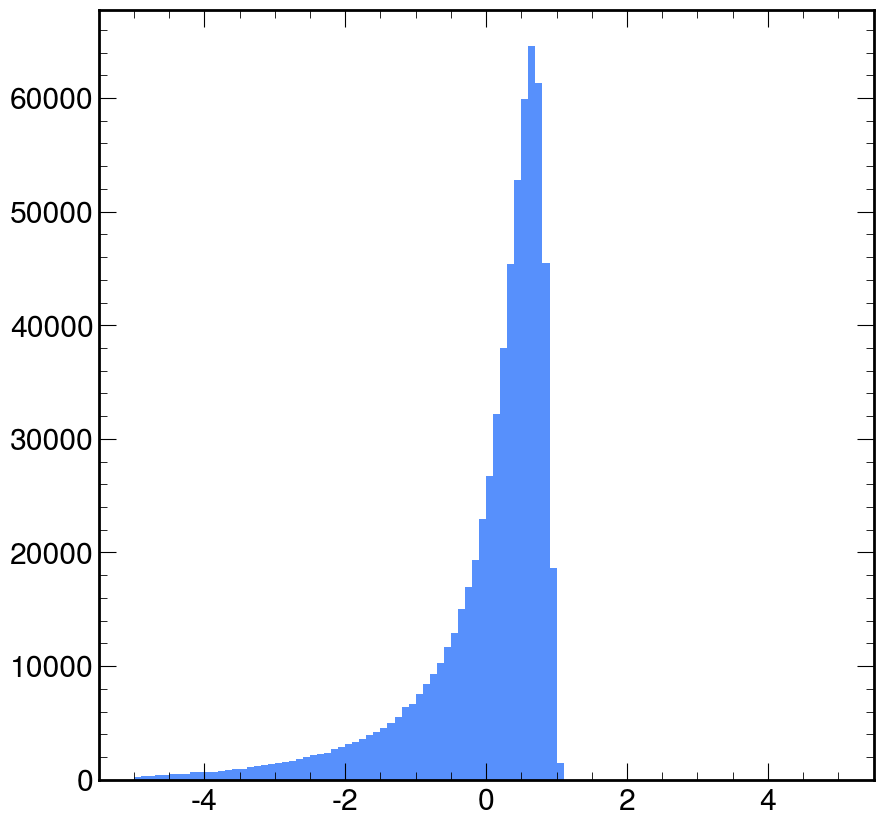

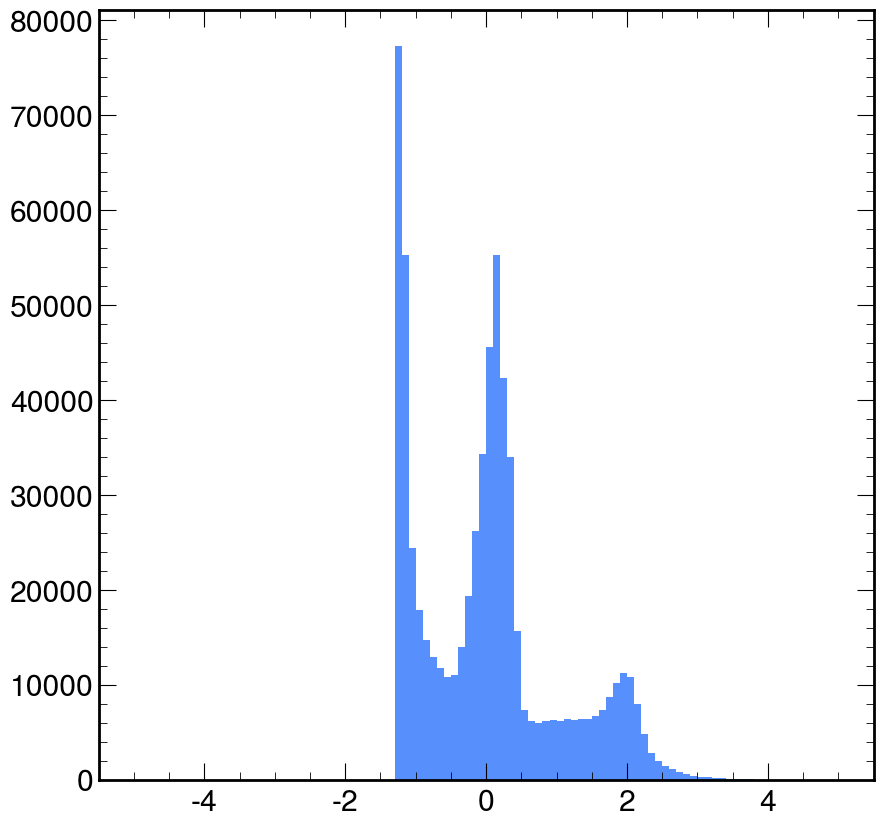

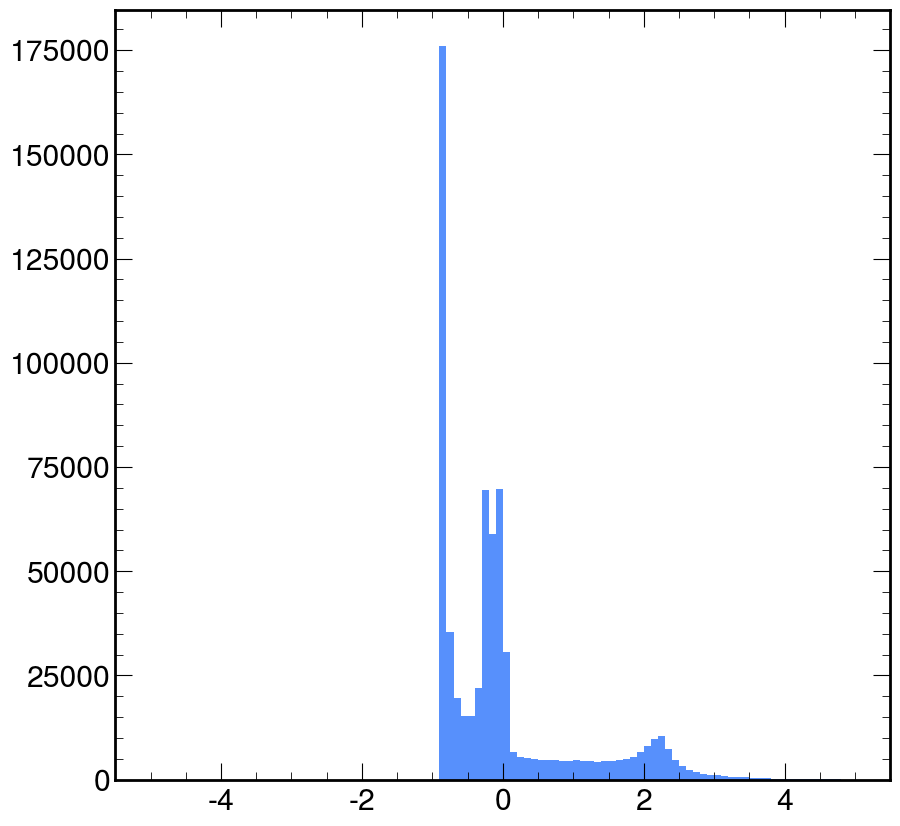

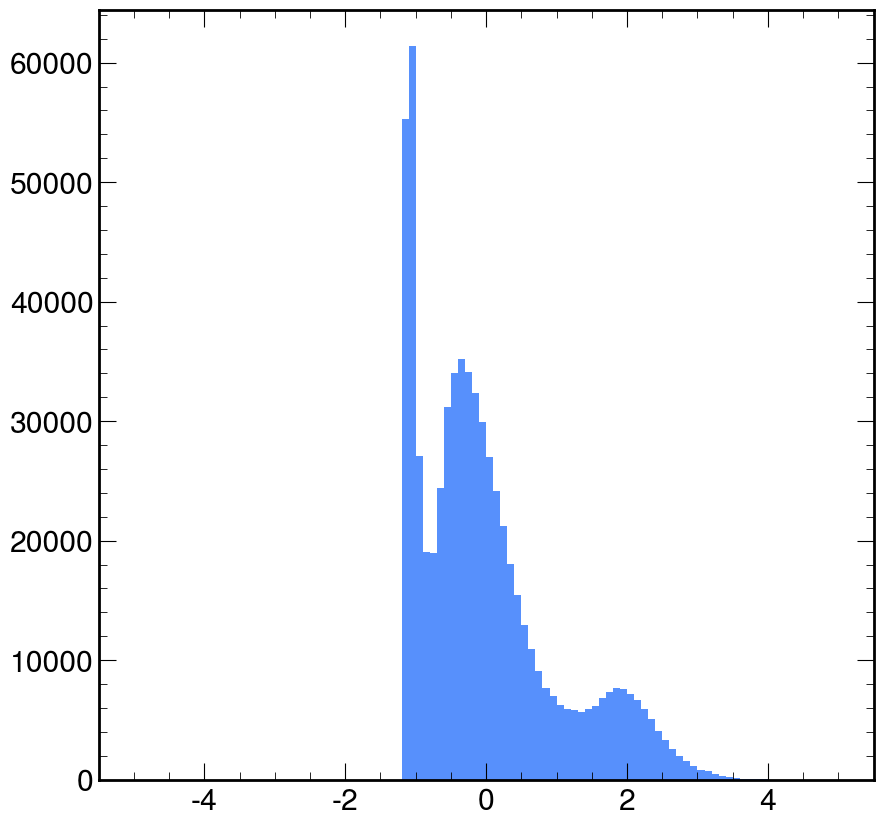

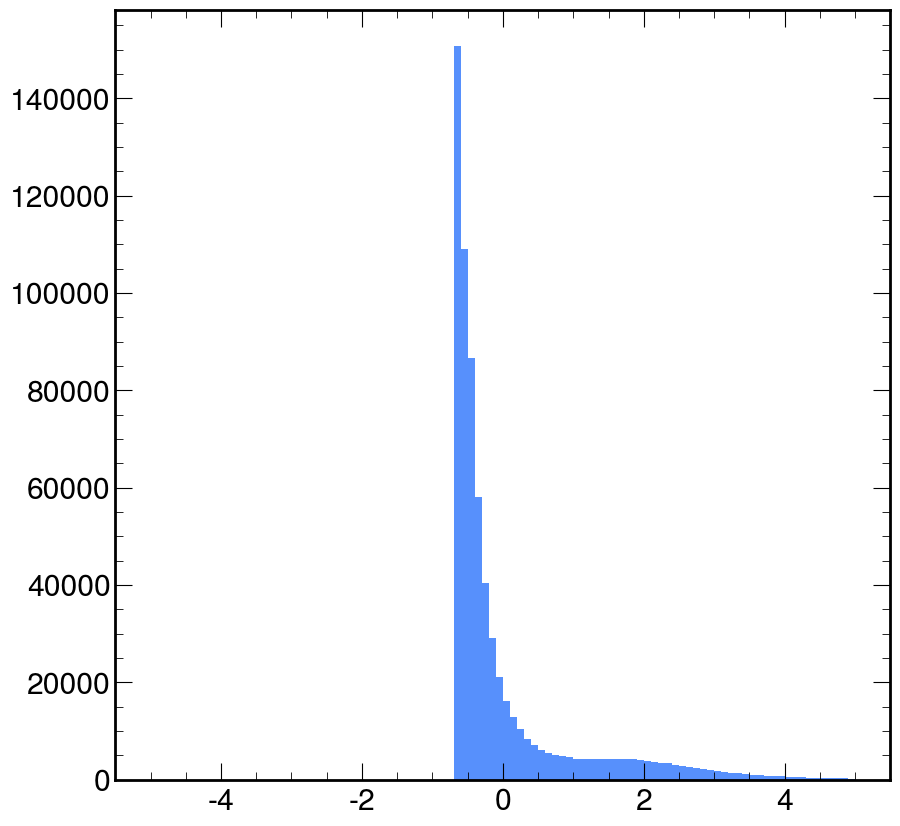

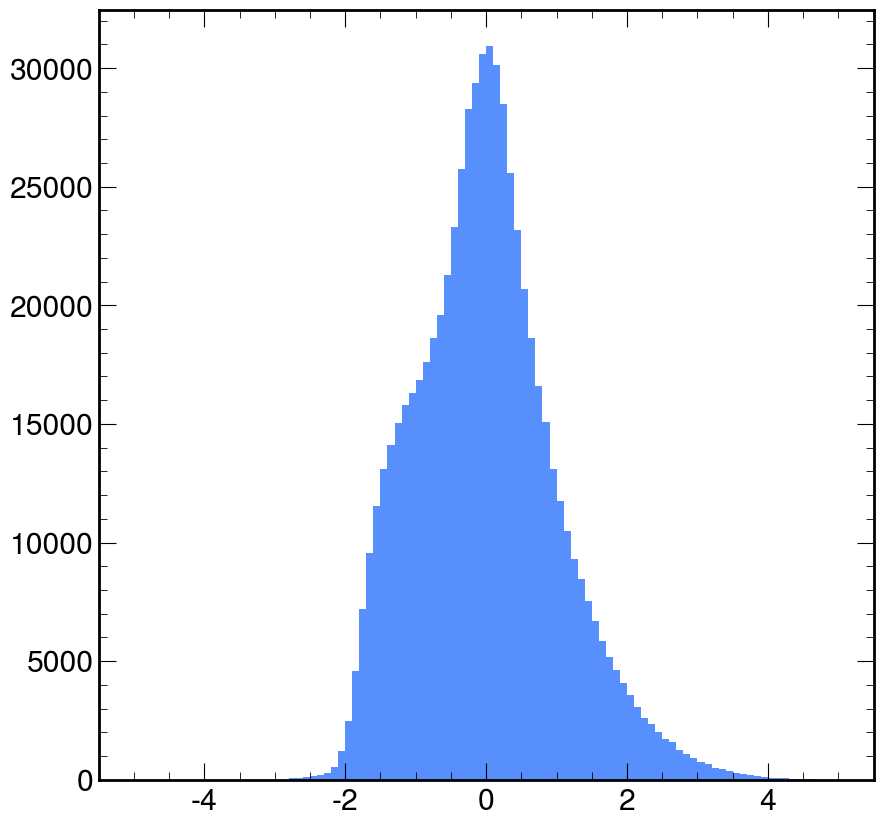

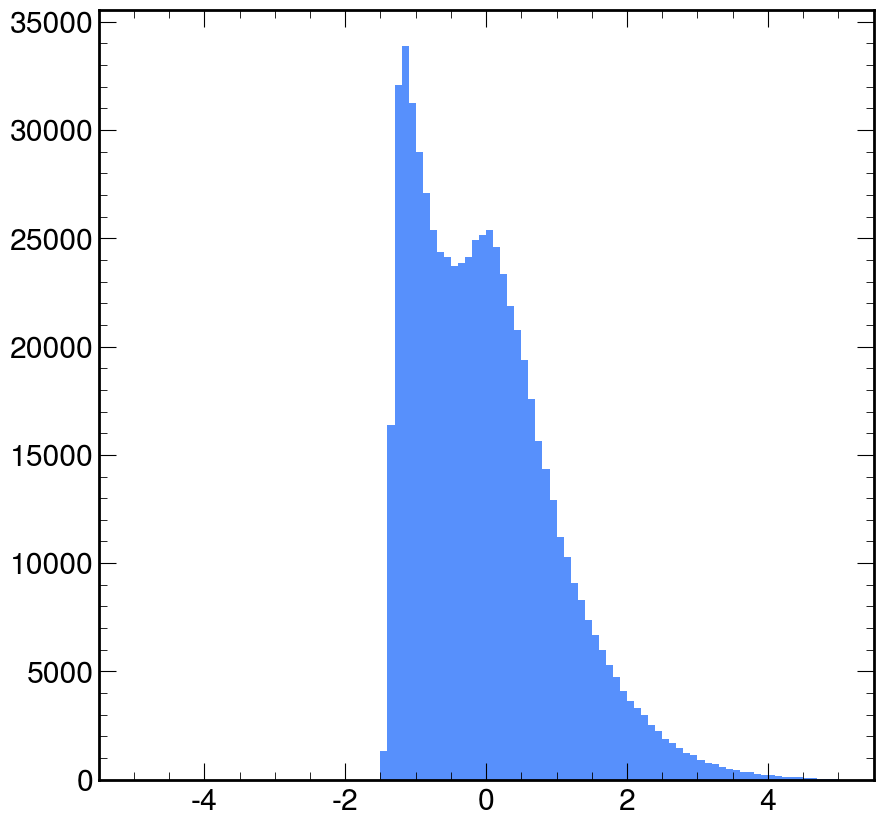

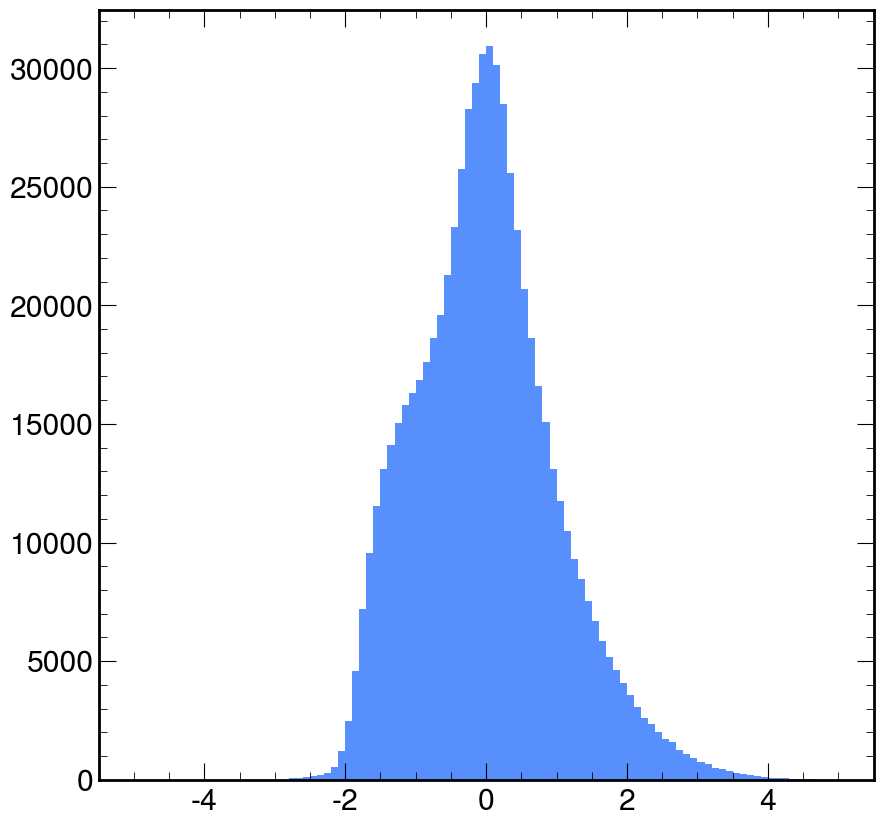

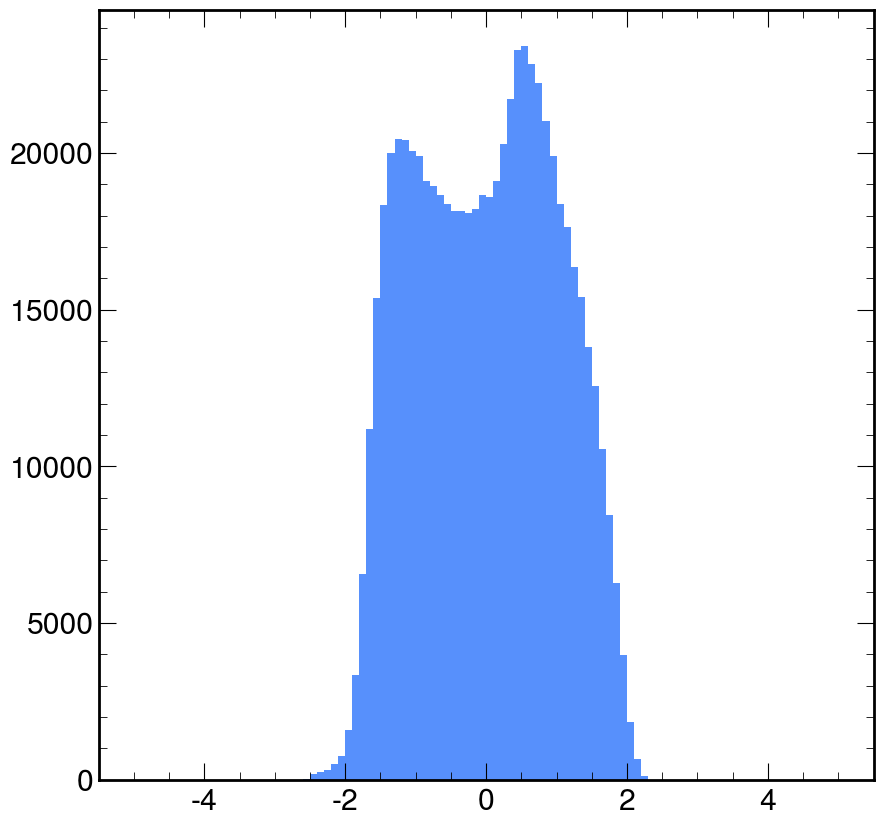

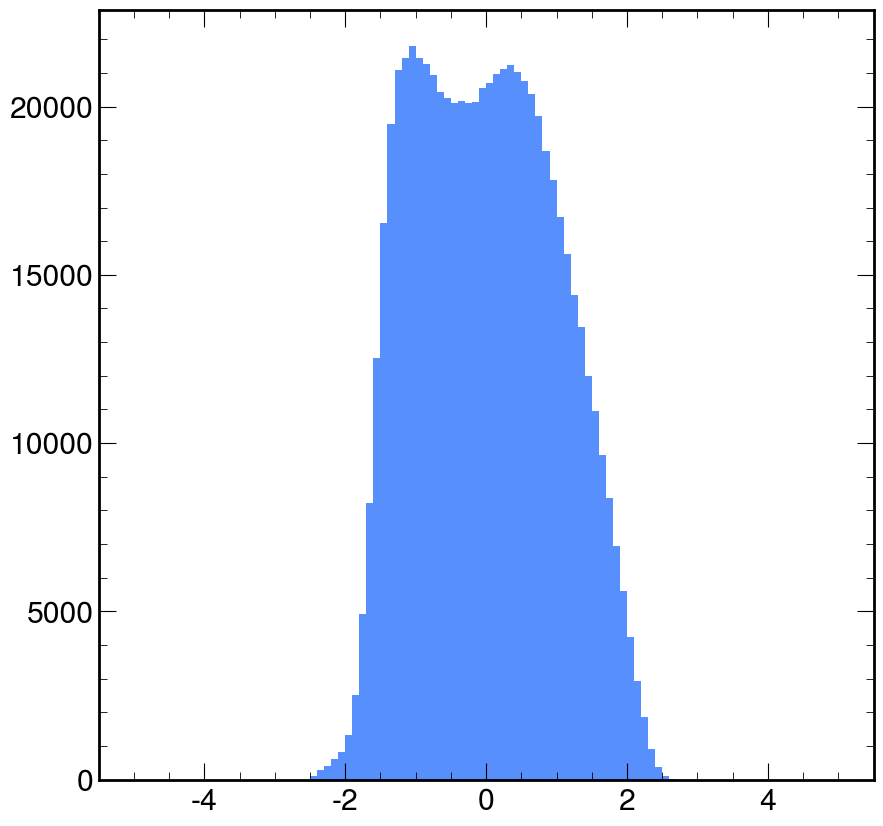

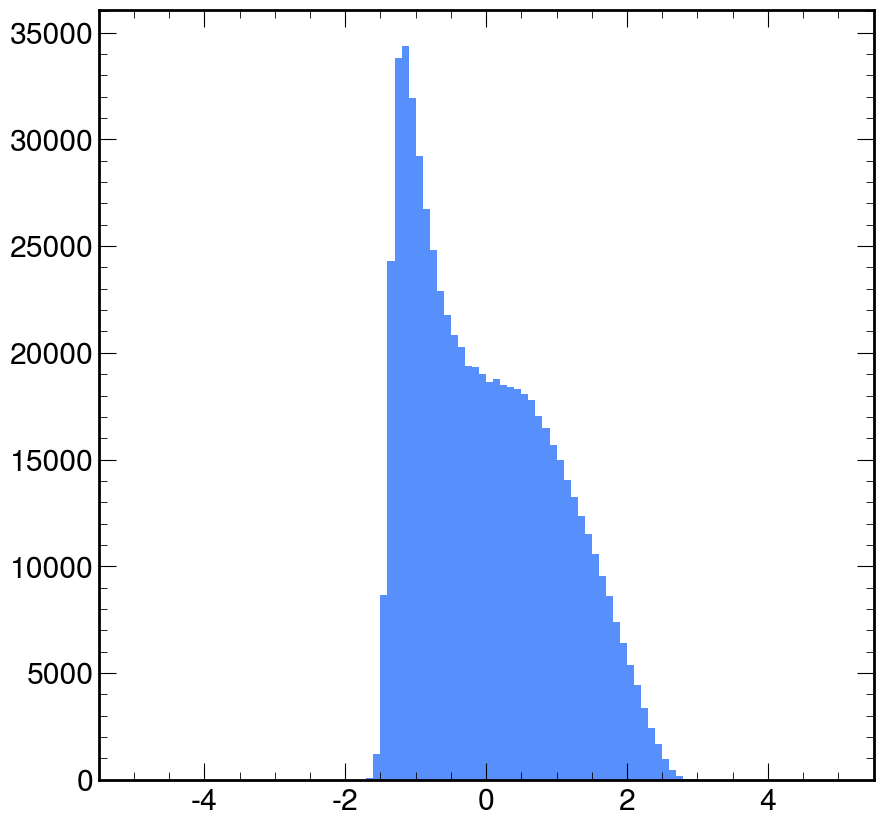

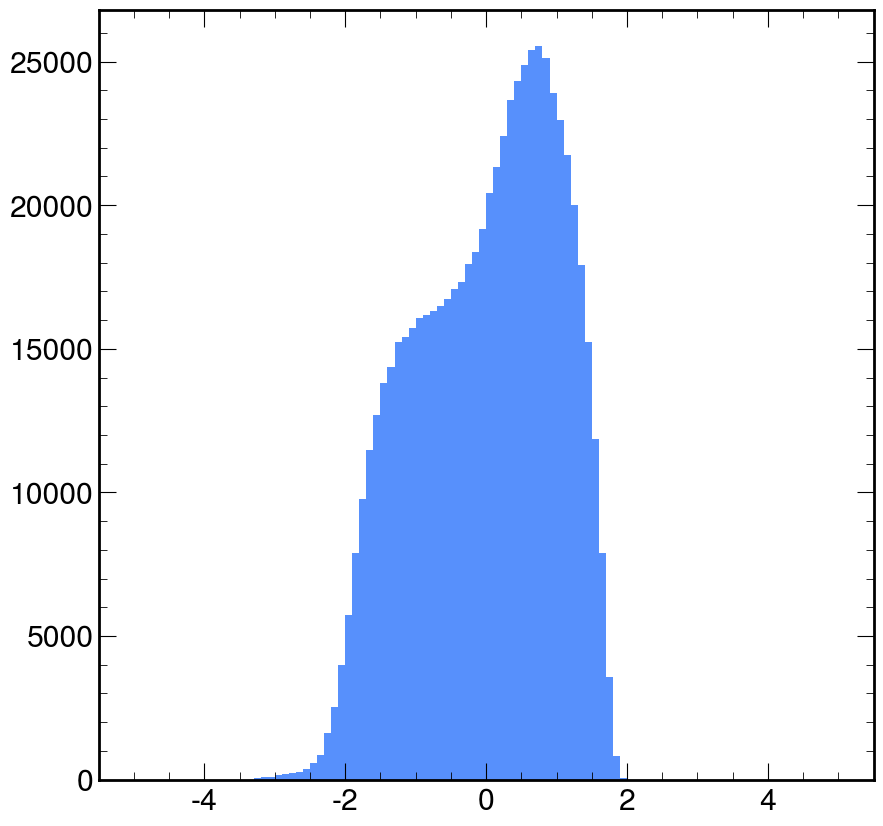

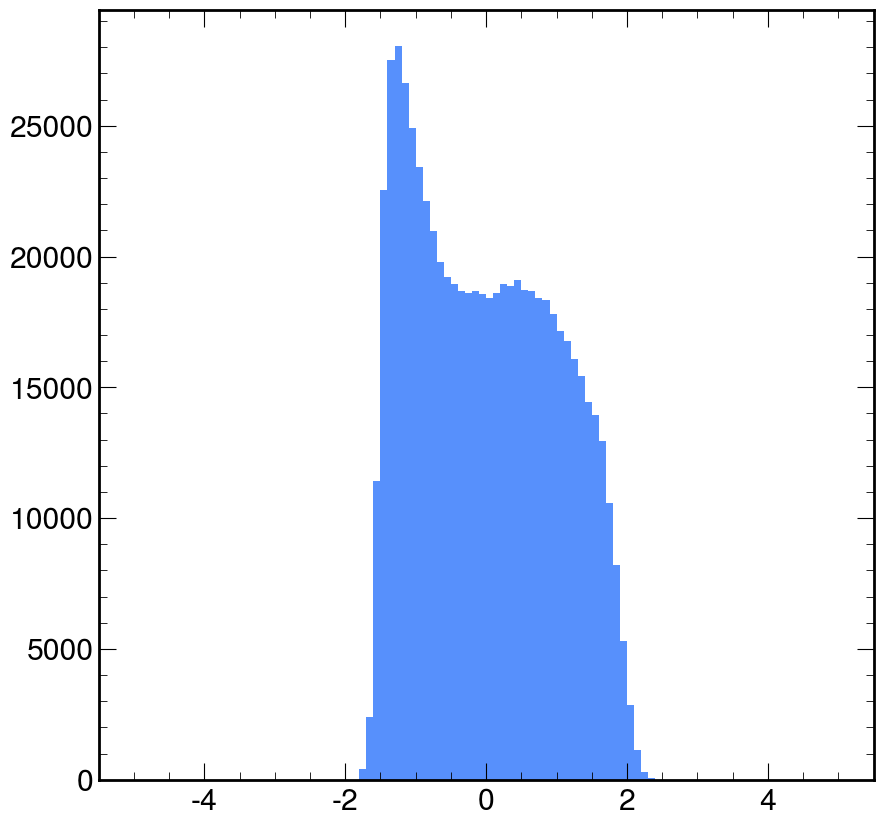

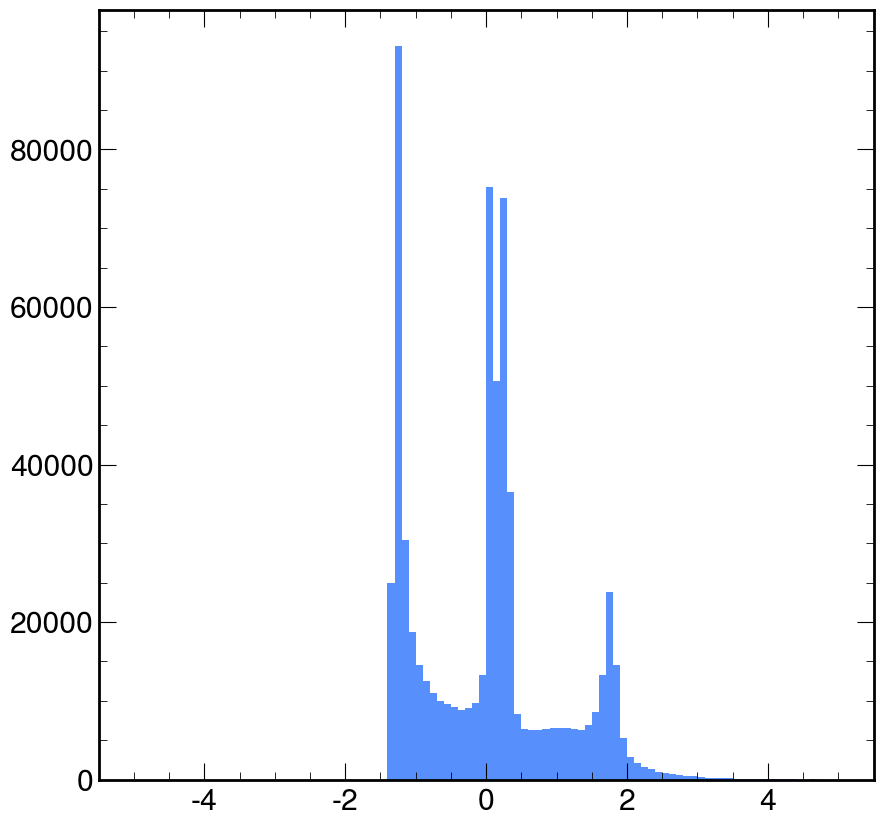

In [16]:
for i in range(15):
    plt.hist(X_train.cpu().numpy()[:,i], bins=100, range=(-5,5))
    plt.show()

In [10]:
model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [11]:
training_loss = []
testing_loss = []

# Define loss
criterion = nn.CrossEntropyLoss()
for epoch in range(15):
    # Train
    model.train()
    epoch_train_loss = 0  # Initialize loss for the epoch
    total_batches = 0
    with tqdm(trainloader) as pbar:
        for i, (inputs, labels) in enumerate(pbar):
            inputs = inputs.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels.to(device))
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            total_batches += 1

            accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])
    
    average_train_loss = epoch_train_loss / total_batches
    training_loss.append(average_train_loss)  # Record the average training loss

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            output = model(inputs)
            val_loss += criterion(output, labels.to(device)).item()
            val_accuracy += (
                (output.argmax(dim=1) == labels.to(device)).float().mean().item()
            )
    val_loss /= len(testloader)
    val_accuracy /= len(testloader)
    testing_loss.append(val_loss)

    # Update learning rate
    scheduler.step()

    print(
        f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
    )

100%|██████████| 10375/10375 [00:17<00:00, 594.62it/s, accuracy=0.656, loss=0.846, lr=0.0001]


Epoch 1, Val Loss: 0.7226205189570888, Val Accuracy: 0.74350865781537


100%|██████████| 10375/10375 [00:17<00:00, 600.83it/s, accuracy=0.75, loss=0.699, lr=9e-5] 


Epoch 2, Val Loss: 0.7018415600337151, Val Accuracy: 0.7505561713080454


100%|██████████| 10375/10375 [00:15<00:00, 658.95it/s, accuracy=0.797, loss=0.622, lr=8.1e-5]


Epoch 3, Val Loss: 0.6916826616343665, Val Accuracy: 0.7534534824105897


100%|██████████| 10375/10375 [00:15<00:00, 656.98it/s, accuracy=0.688, loss=0.694, lr=7.29e-5]


Epoch 4, Val Loss: 0.6848161766390297, Val Accuracy: 0.7558147006064263


100%|██████████| 10375/10375 [00:15<00:00, 658.93it/s, accuracy=0.641, loss=0.906, lr=6.56e-5]


Epoch 5, Val Loss: 0.6800331352716606, Val Accuracy: 0.7575976612849151


100%|██████████| 10375/10375 [00:15<00:00, 658.13it/s, accuracy=0.828, loss=0.538, lr=5.9e-5]


Epoch 6, Val Loss: 0.6765917644835291, Val Accuracy: 0.7582482009919312


100%|██████████| 10375/10375 [00:15<00:00, 665.00it/s, accuracy=0.781, loss=0.618, lr=5.31e-5]


Epoch 7, Val Loss: 0.673796069488768, Val Accuracy: 0.7591999164892328


100%|██████████| 10375/10375 [00:15<00:00, 664.92it/s, accuracy=0.625, loss=0.866, lr=4.78e-5]


Epoch 8, Val Loss: 0.6718043875905672, Val Accuracy: 0.759980965690054


100%|██████████| 10375/10375 [00:15<00:00, 665.10it/s, accuracy=0.828, loss=0.511, lr=4.3e-5]


Epoch 9, Val Loss: 0.6699427517221447, Val Accuracy: 0.7605893407864303


100%|██████████| 10375/10375 [00:15<00:00, 665.02it/s, accuracy=0.781, loss=0.663, lr=3.87e-5]


Epoch 10, Val Loss: 0.6685077130403901, Val Accuracy: 0.7612981078205608


100%|██████████| 10375/10375 [00:15<00:00, 665.17it/s, accuracy=0.703, loss=0.75, lr=3.49e-5] 


Epoch 11, Val Loss: 0.6673683769880301, Val Accuracy: 0.7614727897789263


100%|██████████| 10375/10375 [00:15<00:00, 665.15it/s, accuracy=0.797, loss=0.567, lr=3.14e-5]


Epoch 12, Val Loss: 0.6665248794792796, Val Accuracy: 0.7618161301798515


100%|██████████| 10375/10375 [00:15<00:00, 665.20it/s, accuracy=0.781, loss=0.566, lr=2.82e-5]


Epoch 13, Val Loss: 0.6658385265144644, Val Accuracy: 0.7619807729375482


100%|██████████| 10375/10375 [00:15<00:00, 665.12it/s, accuracy=0.703, loss=0.779, lr=2.54e-5]


Epoch 14, Val Loss: 0.6651896945012011, Val Accuracy: 0.762051047296274


100%|██████████| 10375/10375 [00:15<00:00, 665.21it/s, accuracy=0.719, loss=0.732, lr=2.29e-5]


Epoch 15, Val Loss: 0.6645958411780889, Val Accuracy: 0.7623401760549479


In [ ]:
plt.plot(training_loss, label='KAN Training Loss',linewidth=5)
plt.plot(testing_loss, label='KAN Testing Loss',linewidth=5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()